## Loading the dataset

In [3]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, num_workers=0)

## Visualize the Data

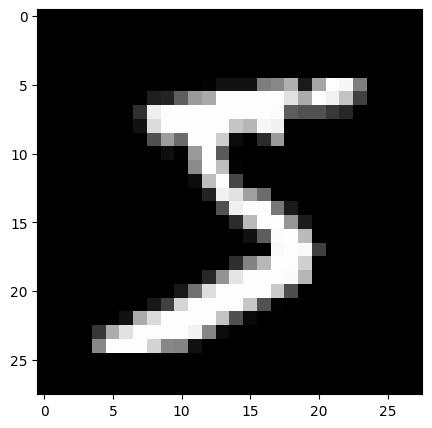

In [14]:
import matplotlib.pyplot as plt

# obtain one batch of training images
dataiter = next(iter(train_loader))
images, labels = dataiter
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Linear Autoencoder

![image](img/autoencoder_1.png)

In [28]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super().__init__()
        ## encoder ##
        # linear layer (784 -> encoding_dim)
        self.fc1 = nn.Linear(28 * 28, encoding_dim)
        
        ## decoder ##
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(encoding_dim, 28*28)
        

    def forward(self, x):
        # add layer, with relu activation function
        x = F.relu(self.fc1(x))
        # output layer (sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.fc2(x))
        return x

# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=784, bias=True)
)


## Training Autoencoder

In [31]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

## Checking out the results

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)